In [2]:
import torch
import gpytorch
from data import PVWeatherLoader

In [198]:
# data parameters
DAY_INIT = 40
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 60
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 3
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (55, -1.5)
RADIUS = 0.3
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [199]:
loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 1 sec



/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/data/utils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('season', axis=1, inplace=True)


In [200]:
from data.utils import train_test_split

dict_input = {
    'x_train': [],
    'y_train': [],
    'x_test': [],
    'y_test': [],
    'task_indices_train': [],
    'task_indices_test': []
}

for i, (X, y) in enumerate(loader):
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=60, day_min=DAY_MIN, day_max=DAY_MAX, n_hours=12)
    n_tr = x_train.size(0)
    print(n_tr)
    n_te = x_test.size(0)
    index_tr = torch.ones(n_tr, dtype=torch.long) * i
    index_te = torch.ones(n_te, dtype=torch.long) * i
    
    dict_input['x_train'].append(x_train)
    dict_input['y_train'].append(y_train)
    dict_input['x_test'].append(x_test)
    dict_input['y_test'].append(y_test)
    dict_input['task_indices_train'].append(index_tr)
    dict_input['task_indices_test'].append(index_te)

task_indices_train = torch.cat(dict_input['task_indices_train'])
task_indices_test = torch.cat(dict_input['task_indices_test'])
x_train = torch.cat(dict_input['x_train'])
x_test = torch.cat(dict_input['x_test'])
y_train = torch.stack(dict_input['y_train'], dim=-1)
y_test = torch.stack(dict_input['y_test'], dim=-1)

# y_train = torch.cat(dict_input['y_train'])
# y_test = torch.cat(dict_input['y_test'])

# for visualizing
# _y_tr = torch.stack(dict_input['y_train'], dim=-1)
# _y_te = torch.stack(dict_input['y_test'], dim=-1)



65
65
65
65
65
65
65
65


In [201]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, task_indices_train.shape, task_indices_test.shape

(torch.Size([520, 5]),
 torch.Size([65, 8]),
 torch.Size([96, 5]),
 torch.Size([12, 8]),
 torch.Size([520]),
 torch.Size([96]))

In [196]:
print(task_indices_train)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])


In [185]:
import torch
from linear_operator.operators import RootLinearOperator
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.module import Module
from gpytorch.variational._variational_strategy import _VariationalStrategy

class IndependentMultitaskVariationalStrategy(_VariationalStrategy):
    """
    IndependentMultitaskVariationalStrategy wraps an existing
    :obj:`~gpytorch.variational.VariationalStrategy` to produce vector-valued (multi-task)
    output distributions. Each task will be independent of one another.

    The output will either be a :obj:`~gpytorch.distributions.MultitaskMultivariateNormal` distribution
    (if we wish to evaluate all tasks for each input) or a :obj:`~gpytorch.distributions.MultivariateNormal`
    (if we wish to evaluate a single task for each input).

    The base variational strategy is assumed to operate on a batch of GPs. One of the batch
    dimensions corresponds to the multiple tasks.

    :param ~gpytorch.variational.VariationalStrategy base_variational_strategy: Base variational strategy
    :param int num_tasks: Number of tasks. Should correspond to the batch size of task_dim.
    :param int task_dim: (Default: -1) Which batch dimension is the task dimension
    """

    def __init__(self, base_variational_strategy, num_tasks, task_dim=-1):
        Module.__init__(self)
        self.base_variational_strategy = base_variational_strategy
        self.task_dim = task_dim
        self.num_tasks = num_tasks

    @property
    def prior_distribution(self):
        return self.base_variational_strategy.prior_distribution

    @property
    def variational_distribution(self):
        return self.base_variational_strategy.variational_distribution

    @property
    def variational_params_initialized(self):
        return self.base_variational_strategy.variational_params_initialized

    def kl_divergence(self):
        return super().kl_divergence().sum(dim=-1)

    def __call__(self, x, task_indices=None, prior=False, **kwargs):
        r"""
        See :class:`LMCVariationalStrategy`.
        """
        function_dist = self.base_variational_strategy(x, prior=prior, **kwargs)

        if task_indices is None:
            # Every data point will get an output for each task
            if (
                self.task_dim > 0
                and self.task_dim > len(function_dist.batch_shape)
                or self.task_dim < 0
                and self.task_dim + len(function_dist.batch_shape) < 0
            ):
                return MultitaskMultivariateNormal.from_repeated_mvn(function_dist, num_tasks=self.num_tasks)
            else:
                function_dist = MultitaskMultivariateNormal.from_batch_mvn(function_dist, task_dim=self.task_dim)
                assert function_dist.event_shape[-1] == self.num_tasks
                return function_dist

        else:
            # Each data point will get a single output corresponding to a single task
            if self.task_dim > 0:
                raise RuntimeError(f"task_dim must be a negative indexed batch dimension: got {self.task_dim}.")
            num_batch = len(function_dist.batch_shape)
            task_dim = num_batch + self.task_dim

            # Create a mask to choose specific task assignment
            shape = list(function_dist.batch_shape + function_dist.event_shape)
            shape[task_dim] = 1
            task_indices = task_indices.expand(shape).squeeze(task_dim)

            # Create a mask to choose specific task assignment
            task_mask = torch.nn.functional.one_hot(task_indices, num_classes=self.num_tasks)
            task_mask = task_mask.permute(*range(0, task_dim), *range(task_dim + 1, num_batch + 1), task_dim)

            mean = (function_dist.mean * task_mask).sum(task_dim)
            covar = (function_dist.lazy_covariance_matrix * RootLinearOperator(task_mask[..., None])).sum(task_dim)
            return MultivariateNormal(mean, covar)

In [186]:
class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, x_train, y_train, num_tasks):
        # Let's use a different set of inducing points for each task
        y_train = y_train

        # need to ensure that y_train is in (0, 1)
        if y_train.max() >= 1:
            y_train[y_train >= 1] = 1 - 1e-4
        if y_train.min() <= 0:
            y_train[y_train <= 0] = 1e-4

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            x_train.size(-2), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, x_train, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=1, batch_shape=torch.Size([num_tasks]))

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
    
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [187]:
from kernels import get_mean_covar
from likelihoods import MultitaskBetaLikelihood
num_tasks = 8
mean, covar = get_mean_covar(num_latent=8)
likelihood = MultitaskBetaLikelihood(scale=30, num_tasks=num_tasks)
model = IndependentMultitaskGPModel(
    x_train=x_train,
    y_train=y_train,
    num_tasks=num_tasks)

In [188]:
model.train()
likelihood.train()

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

for i in range(200):
    optimizer.zero_grad()
    output = model(x_train, task_indices=task_indices_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, 10, loss.item()))
    optimizer.step()


RuntimeError: Shape mismatch: objects cannot be broadcast to a single shape

In [167]:
likelihood.scale

tensor([1.3133], grad_fn=<SoftplusBackward0>)

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


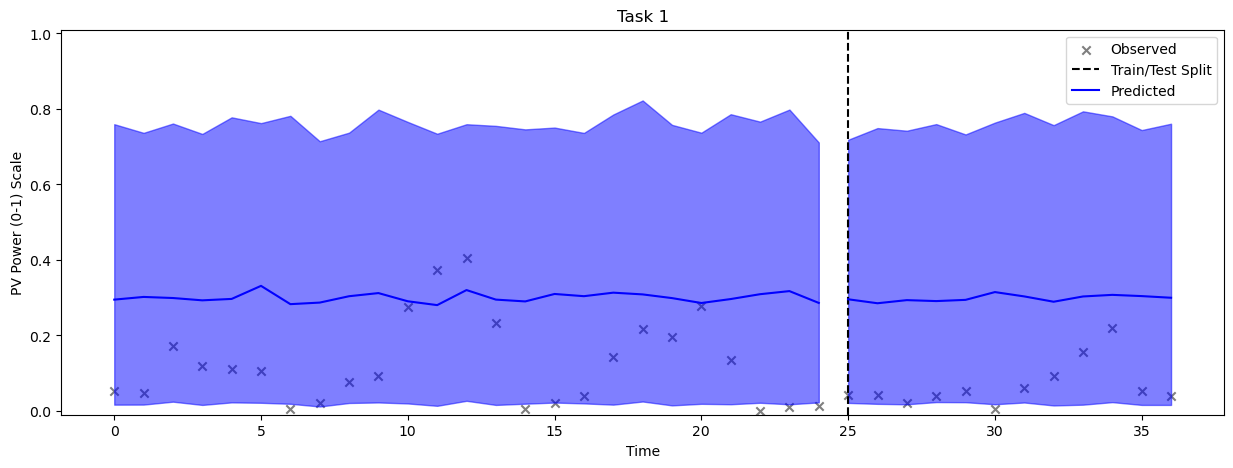

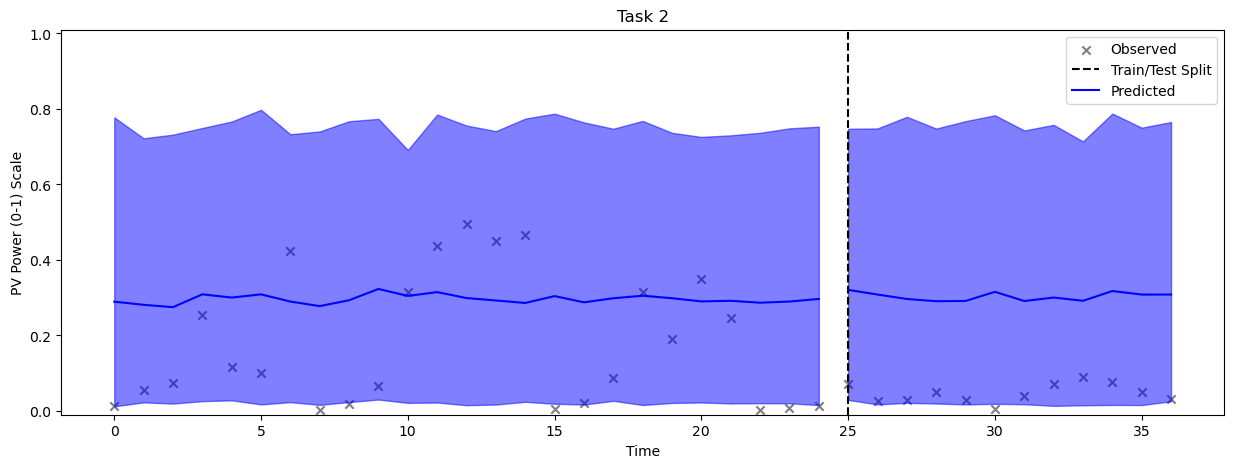

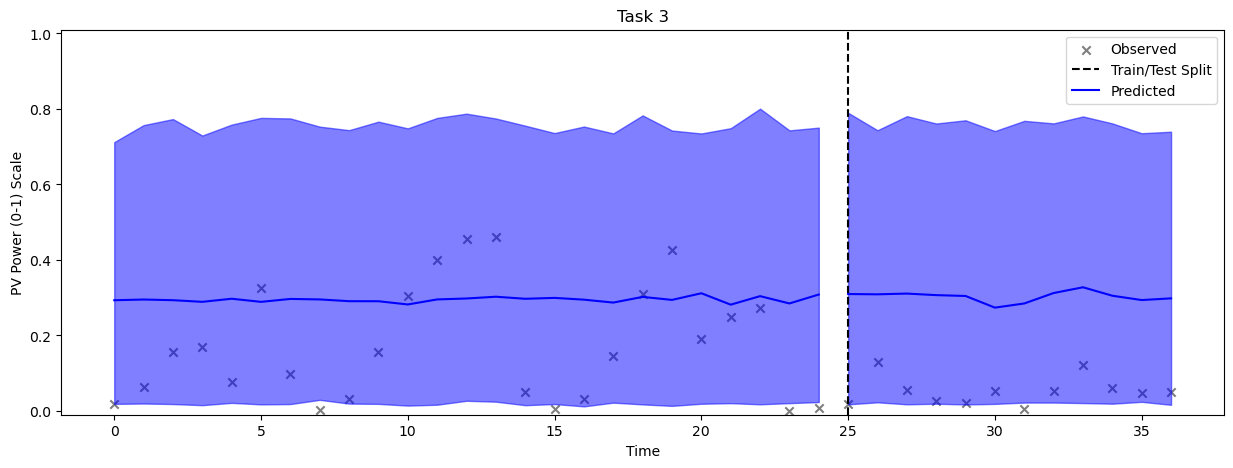

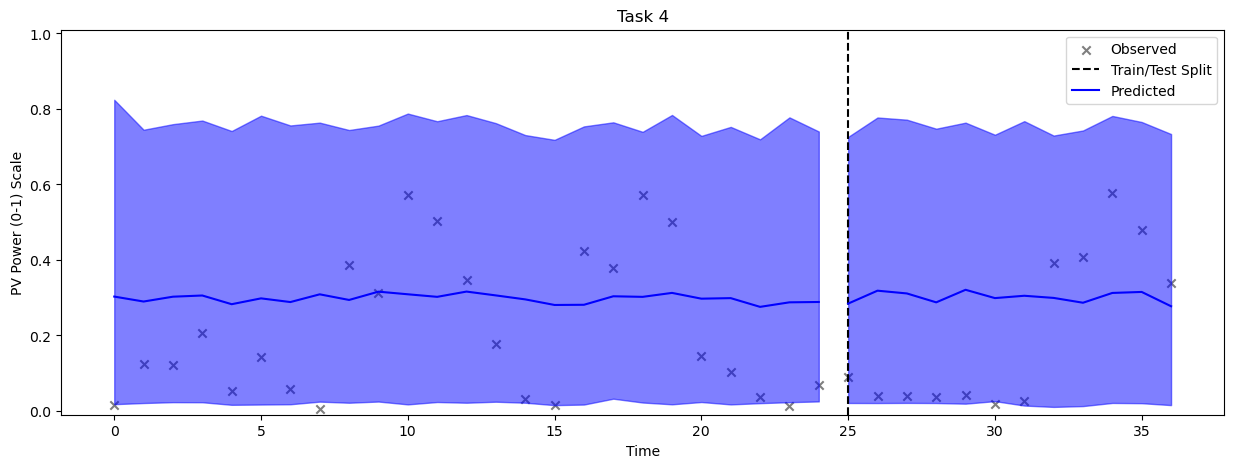

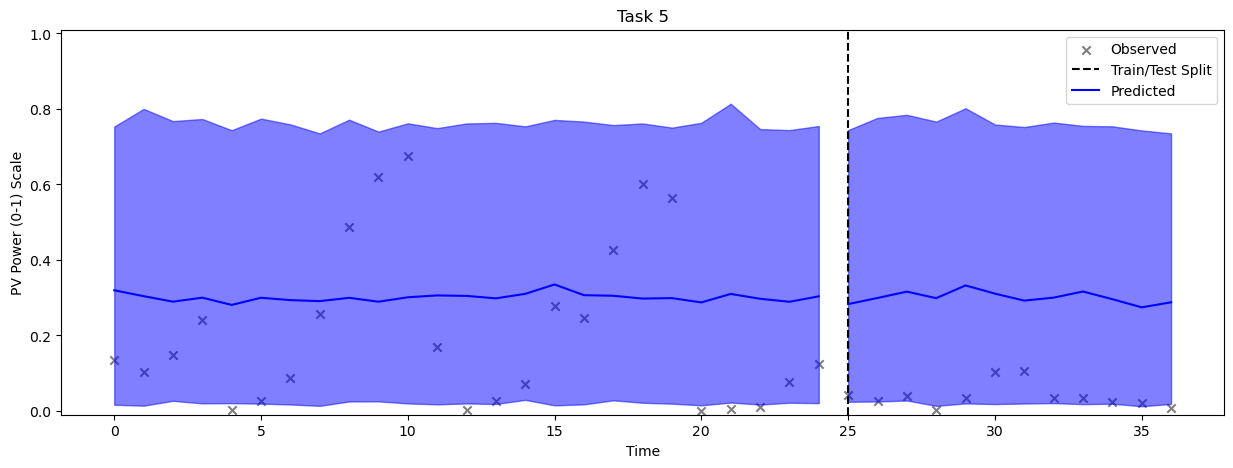

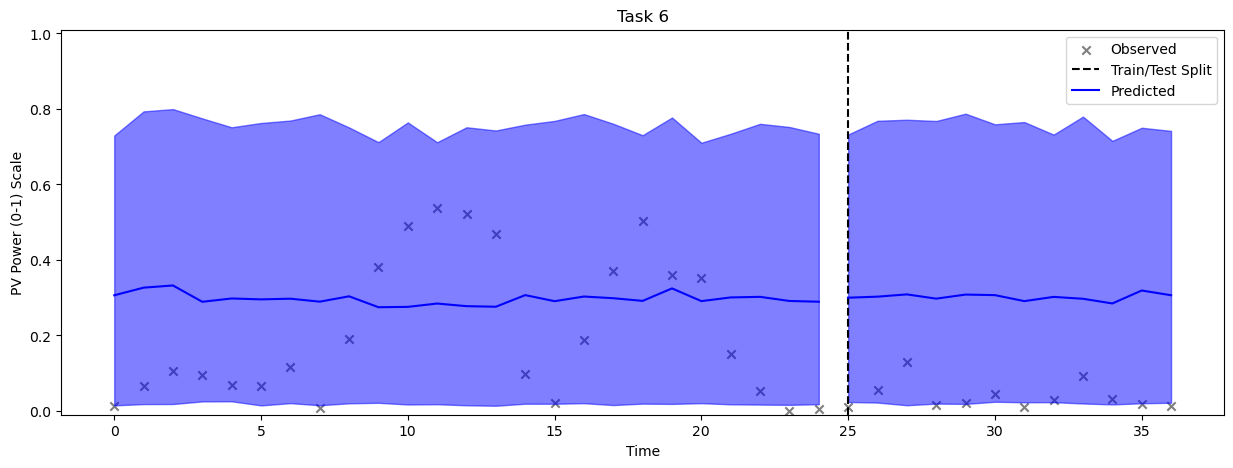

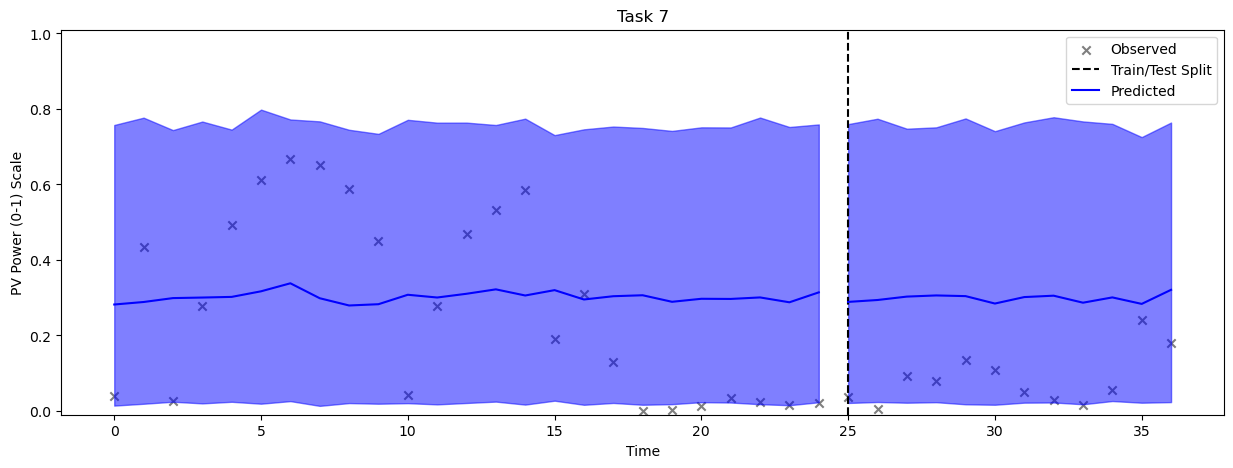

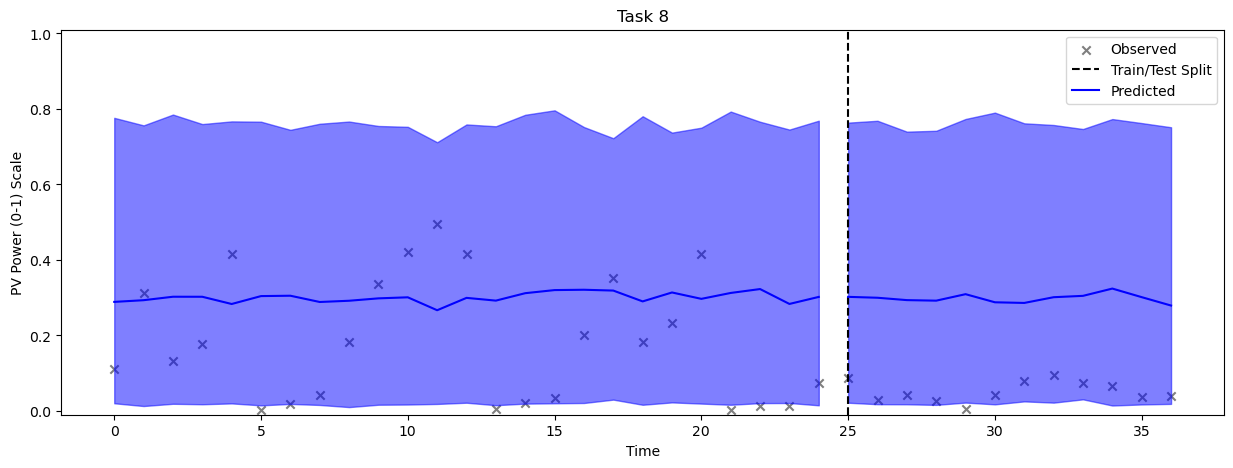

In [168]:
from matplotlib import pyplot as plt
import numpy as np
model.eval()
likelihood.eval()

for i in range(_y_tr.size(-1)):
    y_tr, y_te = _y_tr[:, i], _y_te[:, i]
    t = np.arange(0, len(y_tr) + len(y_te))
    t_tr, t_te = t[:len(y_tr)], t[len(y_tr):]

    plt.figure(figsize=(15,5))
    plt.scatter(t_tr, y_tr, label='Observed', color='black', marker='x', alpha=0.5)
    plt.scatter(t_te, y_te,  color='k', marker='x', alpha=0.5)
    plt.axvline(x=len(y_tr), color='k', linestyle='--', label='Train/Test Split')

    with torch.no_grad():
        pred_dist_tr = likelihood(model(dict_input['x_train'][i], task_indices=dict_input['task_indices_train'][i]))
        pred_dist_te = likelihood(model(dict_input['x_test'][i], task_indices=dict_input['task_indices_test'][i]))

    samples_tr = pred_dist_tr.sample(torch.Size([50]))
    samples_te = pred_dist_te.sample(torch.Size([50]))

    samples_median_tr = samples_tr.mean(dim=0).median(dim=0).values
    lower_tr = np.quantile(samples_tr.detach().numpy(), 0.025, axis=0).mean(axis=0)
    upper_tr = np.quantile(samples_tr.detach().numpy(), 0.975, axis=0).mean(axis=0)


    samples_median_te = samples_te.mean(dim=0).median(dim=0).values
    lower_te = np.quantile(samples_te.detach().numpy(), 0.025, axis=0).mean(axis=0)
    upper_te = np.quantile(samples_te.detach().numpy(), 0.975, axis=0).mean(axis=0)
    
    plt.plot(t_tr, samples_median_tr, label='Predicted', color='blue')
    plt.fill_between(t_tr, lower_tr, upper_tr, alpha=0.5, color='blue')
    plt.plot(t_te, samples_median_te, color='blue')
    plt.fill_between(t_te, lower_te, upper_te, alpha=0.5, color='blue')


    plt.ylim(-0.01, 1.01)
    plt.title(f'Task {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('PV Power (0-1) Scale')
    plt.legend()
    plt.show(); 